In [15]:
from processTools import dbscan, preprocessed_df, show_prediction, reduce_dimensions, relu, simplePrint
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import numpy as np, pandas as pd
from tensorflow import losses, optimizers
from tensorflow.keras import Input, Model, models, layers

C:\Users\mathi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


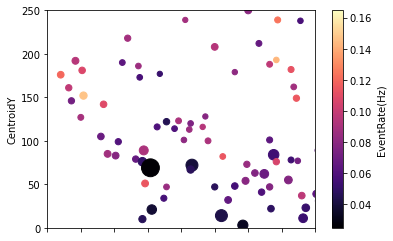

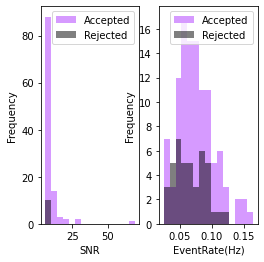

C:\Users\mathi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57,58,59,61,62,63,64,65,67,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,94,95,96,97,98,100,102,103,104,106,107,108,109,110,111,112,114,115,116,121,123,126,132,133,143,144,145) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [16]:
df, loc = preprocessed_df(["data/04042014_2/CellTracing.csv", "data/04042014_2/CellTracing-props.csv"], ['data/04042014_2/events.csv', 'data/04042014_2/events-props.csv'], loc = True)

In [17]:
def createTargets(annot, times = 20):
    result = []
    result.extend([0]*(annot[0])*times)
    for i in range(len(annot)-1):
        if i % 2 == 0:
            result.extend([1]*(annot[i+1] - annot[i])*times)
        else:
            result.extend([0]*(annot[i+1] - annot[i])*times)
    return result

In [18]:
annots = createTargets([88,114, 143,149,164,191, 198,201, 209,212, 224,233, 243,278, 385,393, 1067,1070, 1075,1107, 1116,1126, 1151,1159, 1168,1171, 1201,1208]
)
annots.extend([1]*10)
len(annots)

24170

In [22]:
features =  np.array(df)
x = []
y = []
for i in range(len(features)-21):
    x.append(features[i:i+20])
x_train = np.array(x)


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    x = 1
    y = array.shape[-1]
    while y > x: #Get the closest to a perfect square
        yOld = y
        xOld = x
        for i in range(2,y+1):
            if y%i == 0:
                y = int(y/i)
                x = int(x*i)
                break
        if abs(xOld-yOld) < abs(x-y):
            x = max(xOld, yOld)
            y = min(xOld, yOld)
            break
    print(array.shape)
    try:
        array = np.reshape(array, (array.shape[0], array.shape[1], x, y, 1))
    except:
        array = np.reshape(array, (array.shape[0], x, y, 1))
    return array

x_train = preprocess(x_train)
print(x_train.shape)

(24150, 20, 110)
(24150, 20, 11, 10, 1)


In [36]:
inputs = {}
inputs = Input(shape=(20, 11, 10, 1))

# Encoder
x = layers.Conv3D(32, (3, 3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling3D((4, 3, 3), padding="same")(x)
x = layers.Conv3D(32, (3, 3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling3D((3, 3, 3), padding="same")(x)

# Decoder
x = layers.Conv3DTranspose(32, (3, 3, 3), strides=3, activation="relu", padding="same")(x)
x = layers.Conv3DTranspose(32, (3, 3, 3), strides=4, activation="relu", padding="same")(x)
x = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid', name='center')(x)
# Autoencoder
ae = Model(inputs, output)
ae.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 11, 10, 1)]   0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 20, 11, 10, 32)    896       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 5, 4, 4, 32)       0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 5, 4, 4, 32)       27680     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 2, 2, 2, 32)       0         
_________________________________________________________________
conv3d_transpose_4 (Conv3DTr (None, 6, 6, 6, 32)       27680     
_________________________________________________________________
conv3d_transpose_5 (Conv3DTr (None, 24, 24, 24, 32)    2768

In [39]:
from sklearn.model_selection import train_test_split
dif = len(annots) - len(x_train)
annots = annots[:len(annots)-dif]
annots = np.array(annots)
X_train, X_test, y_train, y_test = train_test_split(x_train, annots, test_size = 0.2, random_state = 1)

In [33]:
X_train.shape

(19320, 20, 11, 10, 1)

In [34]:
y_train.shape

(19320,)

In [40]:
ae.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=128,
    validation_data = (X_test,y_test)
)

Epoch 1/50
151/151 [==============================] - 629s 4s/step - loss: 0.3615 - accuracy: 0.8503 - val_loss: 0.3500 - val_accuracy: 0.8555
Epoch 2/50
151/151 [==============================] - 634s 4s/step - loss: 0.3436 - accuracy: 0.8502 - val_loss: 0.3268 - val_accuracy: 0.8609
Epoch 3/50
151/151 [==============================] - 634s 4s/step - loss: 0.3120 - accuracy: 0.8672 - val_loss: 0.2875 - val_accuracy: 0.8810
Epoch 4/50
151/151 [==============================] - 677s 4s/step - loss: 0.2680 - accuracy: 0.8965 - val_loss: 0.2583 - val_accuracy: 0.9068
Epoch 5/50
151/151 [==============================] - 629s 4s/step - loss: 0.2216 - accuracy: 0.9242 - val_loss: 0.2324 - val_accuracy: 0.9145
Epoch 6/50
151/151 [==============================] - 619s 4s/step - loss: 0.1904 - accuracy: 0.9417 - val_loss: 0.2049 - val_accuracy: 0.9385
Epoch 7/50
151/151 [==============================] - 604s 4s/step - loss: 0.1701 - accuracy: 0.9553 - val_loss: 0.1871 - val_accuracy: 0.9443

In [41]:
sum(annots)/len(annots)

0.14865424430641822

In [2]:
!pip install spektral

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam

from spektral.data import DisjointLoader
from spektral.datasets import TUDataset
from spektral.models import GeneralGNN

In [1]:
data = TUDataset("PROTEINS")


NameError: name 'TUDataset' is not defined

In [2]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

In [3]:
import torch
from torch_geometric.datasets import TUDataset

# Like Spektral, pytorch geometric provides us with benchmark TUDatasets
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')
# Let's take a look at our data. We'll look at dataset (all data) and data (our first graph):

data = dataset[0]  # Get the first graph object.

print()
print(f'Dataset: {dataset}:')
print('====================')
# How many graphs?
print(f'Number of graphs: {len(dataset)}')
# How many features?
print(f'Number of features: {dataset.num_features}')
# Now, in our first graph, how many edges?
print(f'Number of edges: {data.num_edges}')
# Average node degree?
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Do we have isolated nodes?
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# Do we contain self-loops?
print(f'Contains self-loops: {data.contains_self_loops()}')
# Is this an undirected graph?
print(f'Is undirected: {data.is_undirected()}')

NameError: name 'dataset' is not defined